In [103]:
!pip install wandb
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path
import sys
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from types import SimpleNamespace
from matplotlib import pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [104]:
BASE_PATH = str(Path.cwd().resolve()) #
sys.path.append(BASE_PATH)
print(BASE_PATH) 

/home/work/LSTM


In [105]:
CURRENT_FILE_PATH = "/home/work/LSTM"
print(CURRENT_FILE_PATH)
CHECKPOINT_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints")
print(CHECKPOINT_FILE_PATH)

if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(CURRENT_FILE_PATH, "checkpoints"))

/home/work/LSTM
/home/work/LSTM/checkpoints


In [106]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss



In [107]:
def get_num_cpu_cores():
    import multiprocessing
    return multiprocessing.cpu_count()


from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)


def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

In [108]:
class RegressionTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.MSELoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train.squeeze(dim=-1), target_train)

      loss_train += loss.item()

      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains

    return train_loss

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)

        loss_validation += self.loss_fn(output_validation.squeeze(dim=-1), target_validation).item()

        num_validations += 1

    validation_loss = loss_validation / num_validations

    return validation_loss

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 1000 * epoch / elapsed_time.microseconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"V_loss: {validation_loss:7.5f}, "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Validation loss": validation_loss,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

In [135]:
class CryptoCurrencyDataset(Dataset):
    # 암호화폐 데이터셋 클래스 정의
    def __init__(self, X, y, is_regression=True):
        self.X = X  # 입력 데이터
        self.y = y  # 타겟 데이터

        # 입력 데이터와 타겟 데이터의 크기가 동일해야 함
        assert len(self.X) == len(self.y)

    def __len__(self):
        # 데이터셋 크기 반환
        return len(self.X)

    def __getitem__(self, idx):
        # 인덱스에 해당하는 데이터 반환
        X = self.X[idx]
        y = self.y[idx]
        return X, y

    def __str__(self):
        # 데이터셋 정보 문자열 반환
        str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
            len(self.X), self.X.shape, self.y.shape
        )
        return str


def get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    # 암호화폐 데이터 로드 및 전처리 함수
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")  # 데이터 파일 경로
    df = pd.read_csv(btc_krw_path)  # 데이터 파일 읽기
    row_size = len(df)  # 전체 데이터의 행 개수

    # 'Date' 컬럼은 제거
    date_list = df['Date']  # 날짜 정보 저장
    df = df.drop(columns=['Date'])

    # 데이터셋 크기 계산
    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    #################################################################################################

    row_cursor = 0  # 데이터 분할을 위한 커서 초기화

    # 학습 데이터 준비
    X_train_list = []
    y_train_regression_list = []
    y_train_classification_list = []
    y_train_date = []
    for idx in range(0, train_size):
        # 시퀀스 데이터를 추출
        sequence_data = df.iloc[idx: idx + sequence_size].values  # (sequence_size, 5)
        X_train_list.append(torch.from_numpy(sequence_data))  # 입력 데이터 추가

        # 회귀 타겟 데이터
        y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
        # 분류 타겟 데이터
        y_train_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        # 타겟 날짜 저장
        y_train_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    # 학습 데이터 텐서로 변환
    X_train = torch.stack(X_train_list, dim=0).to(torch.float)
    y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
    y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

    # 학습 데이터 정규화 (평균과 표준편차 계산 후 정규화)
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    X_train = (X_train - m) / s

    #################################################################################################

    # 검증 데이터 준비
    X_validation_list = []
    y_validation_regression_list = []
    y_validation_classification_list = []
    y_validation_date = []
    for idx in range(row_cursor, row_cursor + validation_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # (sequence_size, 5)
        X_validation_list.append(torch.from_numpy(sequence_data))  # 입력 데이터 추가

        # 회귀 타겟 데이터
        y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
        # 분류 타겟 데이터
        y_validation_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        # 타겟 날짜 저장
        y_validation_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    # 검증 데이터 텐서로 변환
    X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
    y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
    y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

    # 검증 데이터 정규화
    X_validation = (X_validation - m) / s

    #################################################################################################

    # 테스트 데이터 준비
    X_test_list = []
    y_test_regression_list = []
    y_test_classification_list = []
    y_test_date = []
    for idx in range(row_cursor, row_cursor + test_size):
        sequence_data = df.iloc[idx: idx + sequence_size].values  # (sequence_size, 5)
        X_test_list.append(torch.from_numpy(sequence_data))  # 입력 데이터 추가

        # 회귀 타겟 데이터
        y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
        # 분류 타겟 데이터
        y_test_classification_list.append(
            1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
        )
        # 타겟 날짜 저장
        y_test_date.append(date_list[idx + sequence_size])
        row_cursor += 1

    # 테스트 데이터 텐서로 변환
    X_test = torch.stack(X_test_list, dim=0).to(torch.float)
    y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
    y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

    # 테스트 데이터 정규화
    X_test = (X_test - m) / s

    #################################################################################################

    # 데이터 반환 (회귀 또는 분류에 따라)
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train_regression, y_validation_regression, y_test_regression,
            y_train_date, y_validation_date, y_test_date
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train_classification, y_validation_classification, y_test_classification,
            y_train_date, y_validation_date, y_test_date
        )


In [136]:
if __name__ == "__main__":
  is_regression = False

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10,
    target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1])
1 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 0, 1, 1])
2 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 1, 0, 0, 1])
3 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0])
4 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 1])
5 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 0])
6 - torch.Size([32, 10, 5]): torch.Size(

In [118]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader

# 문제 1번 
### URL_1 :  https://wandb.ai/persnal/g_lstm_regression_btc_krw/runs/k5c7c7tn?nw=nwuserlss523012



In [57]:
import argparse
from f_arg_parser import get_parser 

def get_model():
    # LSTM 기반의 딥러닝 모델 정의
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output):
            super().__init__()

            # LSTM 레이어 설정
            self.lstm = nn.LSTM(
                input_size=n_input,   # 입력 feature 개수
                hidden_size=128,      # LSTM hidden state 크기
                num_layers=2,         # LSTM 레이어 수
                batch_first=True      # 입력 텐서가 [batch, seq, feature] 형태임을 명시
            )

            # Fully Connected Layer (LSTM의 출력 결과를 활용)
            self.fcn = nn.Linear(
                in_features=128,      # LSTM의 hidden size와 동일
                out_features=n_output # 출력 feature 개수
            )

        def forward(self, x):
            # LSTM 레이어에 입력 x를 통과시킴
            x, hidden = self.lstm(x)

            # 마지막 시퀀스의 hidden state를 추출
            x = x[:, -1, :]  # x.shape: [batch_size, hidden_size]

            # Fully Connected Layer를 통과
            x = self.fcn(x)
            return x

    # 모델 인스턴스 생성
    my_model = MyModel(n_input=5, n_output=1)
    return my_model





def main(args):
    # 실행 시간을 문자열로 저장 (실험 이름에 사용)
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 학습 설정 파라미터 구성
    config = {
        'epochs': args.epochs,                           # 학습 epoch 수
        'batch_size': args.batch_size,                   # 배치 크기
        'validation_intervals': args.validation_intervals, # validation 간격
        'learning_rate': args.learning_rate,             # 학습률
        'early_stop_patience': args.early_stop_patience, # 조기 종료 patience
        'early_stop_delta': args.early_stop_delta,       # 조기 종료 delta 값
        'weight_decay': args.weight_decay               # 가중치 감소 값
    }

    # Weights & Biases 프로젝트 초기화
    project_name = "lstm_regression_btc_krw"  # W&B 프로젝트 이름
    wandb.init(
        mode="online" if args.wandb else "disabled",  # W&B 사용 여부
        project=project_name,                        # 프로젝트 이름
        notes="btc_krw experiment with lstm",        # 실험에 대한 간단한 설명
        tags=["lstm", "regression", "btc_krw"],      # 실험 태그
        name=run_time_str,                           # 실험 이름 (실행 시간)
        config=config                                # 학습 설정 파라미터 전달
    )
    
    # 학습 설정 및 W&B config 확인
    print(args)
    print(wandb.config)

    # 학습 및 validation 데이터 로더 준비
    train_data_loader, validation_data_loader, _ = get_btc_krw_data()

    # 학습 장치 설정 (GPU 사용 가능 여부 확인)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성 및 장치로 이동
    model = get_model()
    model.to(device)

    # 옵티마이저 설정 (Adam 사용)
    optimizer = optim.Adam(
        model.parameters(),
        lr=wandb.config.learning_rate,         # 학습률
        weight_decay=wandb.config.weight_decay # 가중치 감소 값
    )

    # RegressionTrainer 클래스 초기화
    regression_trainer = RegressionTrainer(
        project_name,                 # 프로젝트 이름
        model,                        # 모델
        optimizer,                    # 옵티마이저
        train_data_loader,            # 학습 데이터 로더
        validation_data_loader,       # 검증 데이터 로더
        None,                         # 테스트 데이터 (없음)
        run_time_str,                 # 실행 시간 문자열
        wandb,                        # W&B 객체
        device,                       # 학습 장치
        CHECKPOINT_FILE_PATH          # 체크포인트 파일 경로
    )

    # 학습 루프 실행
    regression_trainer.train_loop()

    # W&B 세션 종료
    wandb.finish()


if __name__ == "__main__":
    # 학습 파라미터 설정
    args = {
        "wandb": True,  # Weights & Biases 사용 여부
        "batch_size": 32,  # 배치 크기
        "epochs": 20,  # 학습 epoch 수
        "learning_rate": 0.001,  # 학습률
        "weight_decay": 0.0001,  # 가중치 감소 값
        "validation_intervals": 1,  # validation 간격
        "early_stop_patience": 5,  # 조기 종료 patience
        "early_stop_delta": 0.01,  # 조기 종료 delta 값
    }

    # 딕셔너리를 Namespace 객체로 변환
    args = SimpleNamespace(**args)
    
    # main 함수 실행
    main(args)


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=20, learning_rate=0.001, weight_decay=0.0001, validation_intervals=1, early_stop_patience=5, early_stop_delta=0.01)
{'epochs': 20, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 0.01, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 0.71096, V_loss: 0.06724, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.003
[Epoch   2] T_loss: 0.03727, V_loss: 0.07389, Early stopping counter: 1 out of 5 | T_time: 00:00:00, T_speed: 0.003
[Epoch   3] T_loss: 0.03584, V_loss: 0.01277, V_loss decreased (0.06724 --> 0.01277). Saving model... | T_time: 00:00:01, T_speed: 0.078
[Epoch   4] T_loss: 0.02626, V_loss: 0.01403, Early stopping counter: 1 out of 5 | T_time: 00:00:01, T_speed: 0.011
[Epoch   5] T_loss: 0.02263, V_loss: 0.00884, Early stopping counter: 2 out of 5 | T_time: 00:00:01, T_speed: 0.007
[Epoch   6] T_loss: 0.01904, V_loss: 0.00783, Early stopping 

Epoch,▁▂▃▄▅▆▇█
Training loss,█▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▆▂▁█▂▂
Validation loss,▇█▂▂▁▁▂▁
Epoch,8
Training loss,0.0171
Training speed (epochs/sec.),0.01071
Validation loss,0.00872


In [133]:
class CryptoCurrencyDataset(Dataset):
  def __init__(self, X, y, is_regression=True):
    self.X = X
    self.y = y

    assert len(self.X) == len(self.y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

  def __str__(self):
    str = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
      len(self.X), self.X.shape, self.y.shape
    )
    return str


def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
  btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )


if __name__ == "__main__":
  is_regression = False

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 1, 0, 0])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 0])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 1, 1, 0])
3 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 0, 0, 1, 1])
4 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0])
5 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1])
6 - torch.Size([32, 21, 5]): torch.Size(

In [59]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()


In [76]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay 
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

In [122]:
if __name__ == "__main__":
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 0, 1])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        0, 0, 0, 1, 0, 1, 1, 0])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0])
3 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        1, 1, 0, 0, 1, 1, 1, 1])
4 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 1, 1])
5 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 1, 1])
6 - torch.Size([32, 21, 5]): torch.Size(

MODEL FILE: /home/work/LSTM/checkpoints/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 452.48 <--> 464.58 (Loss:         12.10)
 1: 378.92 <--> 404.00 (Loss:         25.08)
 2: 450.20 <--> 468.41 (Loss:         18.21)
 3: 383.94 <--> 405.02 (Loss:         21.08)
 4: 429.40 <--> 461.57 (Loss:         32.17)
 5: 447.02 <--> 462.33 (Loss:         15.30)
 6: 414.36 <--> 466.85 (Loss:         52.49)
 7: 388.13 <--> 444.08 (Loss:         55.95)
 8: 398.82 <--> 455.68 (Loss:         56.86)
 9: 440.75 <--> 459.89 (Loss:         19.14)


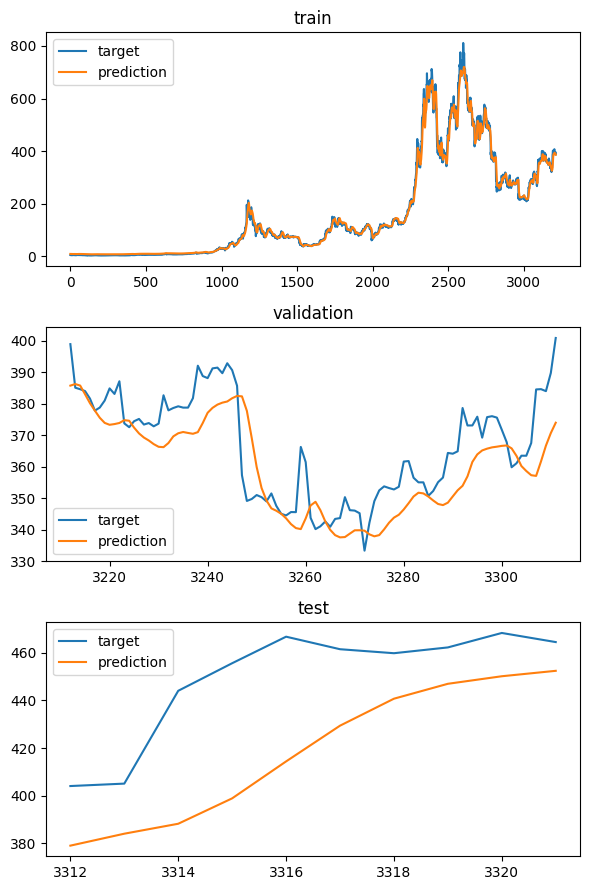

In [62]:
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 5,
    "early_stop_delta": 0.01,
    }  

  args = SimpleNamespace(**args)
  main(args)

# 문제 2
### URL_3  : https://wandb.ai/persnal/g_lstm_regression_btc_krw?nw=nwuserlss523012

1. patience를 15로 증가 히든 사이즈 256  -> valid 0.00879 train  0.01409 로 꽤 validation loss가 줄어든걸 확인 할 수 있었음 hidden과 paience는 고정하고 다른 parameter를 조정

2. 학습률 0.0001로 조정, epoch 100으로 조정 -> epoch 29에서 early stop 
valid : 0.00623 train : 0.01878 로 valid 값과 train 값이 더욱 좋아진 걸 확인 
epoch과 학습률도 고정시킨 후 다른 parameter 확인

3. Layer수를 증가 (2 -> 3) => valid 그래프가 들쑥 날쑥으로 움직이는 걸 확인
valid : 0.00795 train : 0.0179 으로 오히려 valid 값이 증가한걸 보니 Layer는 2개로 하는것이 좋아보임

4. 기존에 것을 나두고  hidden size만 512로 변경 layer = 3개로 진행 -> epoch 15에서 early stop 인걸 확인 patience기준을 기존 절반으로 낮춘후 다시 진행 해보겠음
valid : 0.01001 train : 0.03018 train 로스값과 valid 값의 추이를 확인 했을 때 충분한 epoch 을 돌지 못한것으로 판단함.

5. 4번에서  patience를 20으로 변경  paience 기준을 기존 절반으로 줄임 -> epoch 42에서 early stop valid : 0.00462 train ; 0.01164 valid의 성능 향상을 확인 할 수 있었음

6. 5번의 변경사항을 고정 한 뒤 Layer를 2, 히든 사이즈를 256으로 교체 해보겠음
-> epoch 47 stop valid :; 0.00868 trian : 0.01326 도리어 valid 큰 성능 향상은 보이지 않음

7. 6번에서 히든사이즈를 512로 교체 -> epoch 47 stop valid : 0.006인걸 확인


지금까지의 실험을 토대로 4번 이상의 validation 값을 낼 수 없을거라 생각하여 test를 진행해보기로 함

최종 파라미터 "batch_size": 32, "epochs": 100, "learning_rate": 0.0001, "weight_decay": 0.0001, "validation_intervals": 1, "early_stop_patience": 20, "early_stop_delta": 0.005, 

In [154]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__() 
      self.lstm = nn.LSTM(input_size=n_input, hidden_size=512, num_layers=3, batch_first=True)
      
      self.fcn = nn.Linear(in_features=512, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=1)

  return my_model

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "g_lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
  #parser = get_parser()
  #args = parser.parse_args()
    
  args = {
        "wandb": True,  # Weights & Biases 사용 여부
        "batch_size": 32,  # 배치 크기
        "epochs": 100,  # 학습 epoch 수
        "learning_rate": 0.0001,  # 학습률
        "weight_decay": 0.0001,  # 가중치 감소 값
        "validation_intervals": 1,  # val 간격 (몇 epoch마다 validation 할지)
        "early_stop_patience": 20,  # 조기 종료 patience
        "early_stop_delta": 0.005,  # 조기 종료 delta 값
    }


  args = SimpleNamespace(**args)
  main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=100, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=1, early_stop_patience=20, early_stop_delta=0.005)
{'epochs': 100, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0001, 'early_stop_patience': 20, 'early_stop_delta': 0.005, 'weight_decay': 0.0001}
Training on device cuda:0.
[Epoch   1] T_loss: 1.18764, V_loss: 0.11724, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
[Epoch   2] T_loss: 0.07146, V_loss: 0.02708, V_loss decreased (0.11724 --> 0.02708). Saving model... | T_time: 00:00:01, T_speed: 0.016
[Epoch   3] T_loss: 0.05817, V_loss: 0.02876, Early stopping counter: 1 out of 20 | T_time: 00:00:01, T_speed: 0.004
[Epoch   4] T_loss: 0.05472, V_loss: 0.01956, V_loss decreased (0.02708 --> 0.01956). Saving model... | T_time: 00:00:02, T_speed: 0.011
[Epoch   5] T_loss: 0.04953, V_loss: 0.04708, Early stopping counter: 1 out of 20 | T_time: 00:00:03, T_speed: 0.059
[Epoch   6] T_loss: 0.04998, V

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▅▁▂▁█▁▂▁▂▁▁▁▅▁▁▂▁▂▁
Validation loss,█▂▃▂▄▂▂▂▁▅▂▂▁▁▂▁▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
Epoch,48
Training loss,0.01123
Training speed (epochs/sec.),0.08983
Validation loss,0.00686


In [155]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

if __name__ == "__main__":
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))
    
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "h_lstm_regression_btc_krw"

  tags=list(["lstm", "regression", "btc_krw"])
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=tags,
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "g_lstm_regression_btc_krw"
    
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )

  if not os.path.exists(latest_file_path):
    print(f"File not found: {latest_file_path}")
    print("Please check if the model file exists in the specified path.")
    return

  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

0 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0])
1 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 0, 1])
2 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0])
3 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 0])
4 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 0, 1])
5 - torch.Size([32, 21, 5]): torch.Size([32]), tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 1, 1, 1, 0])
6 - torch.Size([32, 21, 5]): torch.Size(

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/LSTM/checkpoints/g_lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 420.79 <--> 455.68 (Loss:         34.89)
 1: 401.16 <--> 405.02 (Loss:          3.86)
 2: 468.05 <--> 462.33 (Loss:          5.72)
 3: 463.86 <--> 468.41 (Loss:          4.55)
 4: 464.02 <--> 461.57 (Loss:          2.45)
 5: 405.43 <--> 444.08 (Loss:         38.64)
 6: 463.74 <--> 464.58 (Loss:          0.83)
 7: 471.43 <--> 459.89 (Loss:         11.54)
 8: 394.81 <--> 404.00 (Loss:          9.19)
 9: 444.55 <--> 466.85 (Loss:         22.29)


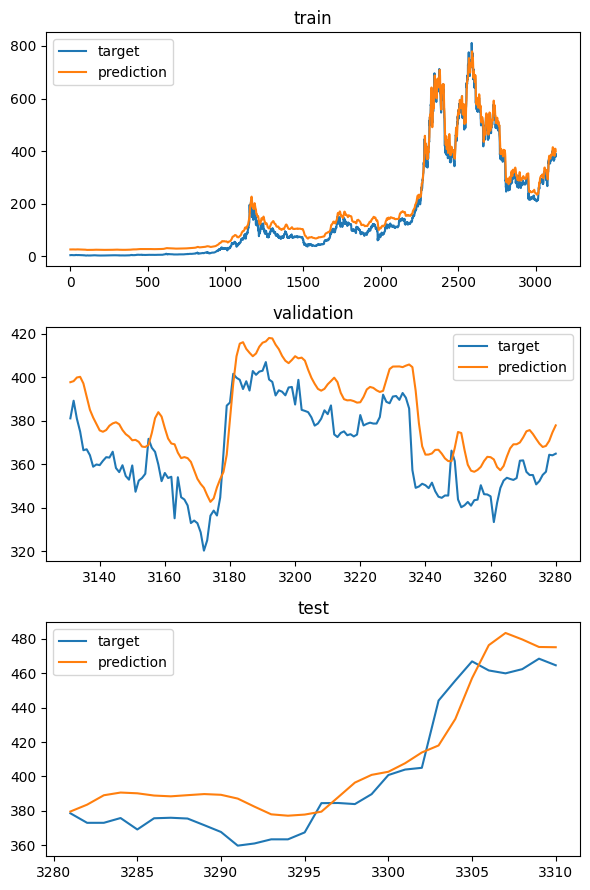

In [156]:
if __name__ == "__main__":
  args = {
        "wandb": True,  # Weights & Biases 사용 여부
        "batch_size": 32,  # 배치 크기
        "epochs": 100,  # 학습 epoch 수
        "learning_rate": 0.0001,  # 학습률
        "weight_decay": 0.0001,  # 가중치 감소 값
        "validation_intervals": 1,  # val 간격 (몇 epoch마다 validation 할지)
        "early_stop_patience": 20,  # 조기 종료 patience
        "early_stop_delta": 0.005,  # 조기 종료 delta 값
    }

  args = SimpleNamespace(**args)
  main(args)

# 문제 3번


In [157]:
#next open 추가
def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=True
):
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
    df = pd.read_csv(btc_krw_path)

    # 'Next_Open' 열 추가
    df['Next_Open'] = df['Open'].shift(-1)  # 'Open' 열을 한 칸 위로 이동
    df = df[:-1]  # 마지막 행 제거 => NaN 발생

    row_size = len(df)
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    # 데이터 전처리 함수 정의
    def process_data(start_idx, size):
        X_list = []
        y_list = []
        date_list_out = []

        for idx in range(start_idx, start_idx + size):
            # 시퀀스 데이터와 Next_Open 병합
            sequence_data = df.iloc[idx: idx + sequence_size].values  # 시퀀스 데이터
            next_open = df.iloc[idx + sequence_size]['Next_Open']  # 다음 Open 값

            # 'Next_Open' 값을 시퀀스 데이터의 추가 ==> feature로 포함
            sequence_with_next_open = np.hstack([sequence_data, [[next_open]] * sequence_size])

            X_list.append(sequence_with_next_open)  # 리스트에 numpy 배열 추가
            if is_regression:
                # 회귀 문제: 타겟 값을 정규화하여 추가
                y_list.append(df.iloc[idx + sequence_size][target_column] / y_normalizer)
            else:
                # 분류 문제: 타겟 클래스(상승/하락) 추가
                y_list.append(
                    1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
                )
            date_list_out.append(date_list[idx + sequence_size])

        # numpy 배열로 변환
        X_array = np.array(X_list, dtype=np.float32)
        y_array = np.array(y_list, dtype=np.float32 if is_regression else np.int64)

        # numpy 배열을 PyTorch 텐서로 변환
        X = torch.tensor(X_array)
        y = torch.tensor(y_array)

        return X, y, date_list_out

    # 학습, val, 테스트 데이터셋 생성
    X_train, y_train, train_dates = process_data(0, train_size)
    X_validation, y_validation, validation_dates = process_data(train_size, validation_size)
    X_test, y_test, test_dates = process_data(train_size + validation_size, test_size)

    # 학습 데이터 정규화 (평균 및 표준편차 계산)
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    # 정규화 적용
    X_train = (X_train - m) / s
    X_validation = (X_validation - m) / s
    X_test = (X_test - m) / s

    # 반환값 구성
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )



if __name__ == "__main__":
    # regression true
    is_regression = True

    # 데이터 로드 및 전처리
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # 학습 데이터셋 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    # 데이터 로더 구성
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )

    # 데이터 로더 확인
    for idx, batch in enumerate(train_data_loader):
        input, target = batch
        print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0.0406, 5.4745, 0.0276, 0.4038, 5.5552, 3.6842, 0.9848, 0.0706, 4.6012,
        0.0416, 6.2026, 1.1173, 0.6453, 2.8766, 1.2530, 1.6642, 0.7857, 0.5037,
        0.0374, 0.8320, 0.8479, 0.0536, 0.0541, 0.2903, 0.0449, 1.5782, 0.0488,
        0.6534, 1.2670, 5.5181, 0.1382, 0.0438])
1 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0.9426, 0.7290, 0.5454, 0.4280, 3.7489, 0.0669, 6.0235, 2.0747, 5.6184,
        2.6752, 3.8647, 1.2210, 5.5871, 0.0517, 0.0306, 1.1990, 5.5022, 0.1126,
        0.4492, 1.2466, 0.7394, 0.0683, 0.0285, 0.0280, 3.6760, 0.0492, 0.4460,
        0.8344, 1.1522, 1.0278, 0.0360, 0.2804])
2 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0.0421, 1.6572, 1.0118, 0.0283, 3.2291, 2.6919, 0.1952, 0.0874, 2.5618,
        0.0461, 2.2230, 0.0304, 0.3877, 0.0394, 5.7900, 0.7893, 2.8965, 0.0899,
        2.0845, 0.1241, 0.3217, 2.7723, 0.0265, 0.7988, 2.0087, 0.2725, 1.2663,
        0.8792, 0.3673, 1.2405, 0.9564, 0

In [191]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__() 
      self.lstm = nn.LSTM(input_size=n_input, hidden_size=512, num_layers=3, batch_first=True)
      
      self.fcn = nn.Linear(in_features=512, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=7, n_output=1)

  return my_model

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "g_lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model()
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  regression_trainer.train_loop()

  wandb.finish()

if __name__ == "__main__":
  #parser = get_parser()
  #args = parser.parse_args()
    
  args = {
        "wandb": True,  # Weights & Biases 사용 여부
        "batch_size": 32,  # 배치 크기
        "epochs": 100,  # 학습 epoch 수
        "learning_rate": 0.0001,  # 학습률
        "weight_decay": 0.0001,  # 가중치 감소 값
        "validation_intervals": 1,  # val 간격 (몇 epoch마다 validation 할지)
        "early_stop_patience": 20,  # 조기 종료 patience
        "early_stop_delta": 0.005,  # 조기 종료 delta 값
    }


  args = SimpleNamespace(**args)
  main(args)

namespace(wandb=True, batch_size=32, epochs=100, learning_rate=0.0001, weight_decay=0.0001, validation_intervals=1, early_stop_patience=20, early_stop_delta=0.005)
{'epochs': 100, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0001, 'early_stop_patience': 20, 'early_stop_delta': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 1.34212, V_loss: 0.01211, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
[Epoch   2] T_loss: 0.05566, V_loss: 0.00951, Early stopping counter: 1 out of 20 | T_time: 00:00:01, T_speed: 0.015
[Epoch   3] T_loss: 0.03275, V_loss: 0.01276, Early stopping counter: 2 out of 20 | T_time: 00:00:01, T_speed: 0.004
[Epoch   4] T_loss: 0.01636, V_loss: 0.00568, V_loss decreased (0.01211 --> 0.00568). Saving model... | T_time: 00:00:02, T_speed: 0.015
[Epoch   5] T_loss: 0.00367, V_loss: 0.00068, V_loss decreased (0.00568 --> 0.00068). Saving model... | T_time: 00:00:02, T_speed: 0.005
[Epoch   6] T_loss: 0.00225, V_loss: 0.00046, Early st

## 문제 3 next_open 열 추가 이후 성능 변화
### URL_5 : https://wandb.ai/persnal/h_lstm_regression_btc_krw/runs/73tnst11?nw=nwuserlss523012


-> validation loss에 있어서 정말 큰 성능 향상이 있는 것으로 확인됨 그래프의 모양이 분명히 비슷한데 무언가가 편향이 들어가있는지 그래프가 합쳐져 있지 않음....

In [192]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data()

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=21, validation_size=150, test_size=30,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

if __name__ == "__main__":
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30,
    target_column='Close', y_normalizer=1.0e7, is_regression=False
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))
    
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "h_lstm_regression_btc_krw"

  tags=list(["lstm", "regression", "btc_krw"])
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=tags,
    name=run_time_str,
    config=config
  )

  test_model = get_model()

  project_name = "g_lstm_regression_btc_krw"
    
  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )

  if not os.path.exists(latest_file_path):
    print(f"File not found: {latest_file_path}")
    print("Please check if the model file exists in the specified path.")
    return

  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

0 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 0])
1 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
2 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 1, 1, 0, 1])
3 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0])
4 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 1])
5 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1])
6 - torch.Size([32, 21, 7]): torch.Size(

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/LSTM/checkpoints/g_lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 393.38 <--> 400.82 (Loss:          7.44)
 1: 456.40 <--> 462.33 (Loss:          5.93)
 2: 463.10 <--> 468.41 (Loss:          5.32)
 3: 452.13 <--> 459.89 (Loss:          7.76)
 4: 450.73 <--> 461.57 (Loss:         10.84)
 5: 441.49 <--> 455.68 (Loss:         14.19)
 6: 396.92 <--> 404.00 (Loss:          7.08)
 7: 452.57 <--> 466.85 (Loss:         14.27)
 8: 400.39 <--> 405.02 (Loss:          4.63)
 9: 430.29 <--> 444.08 (Loss:         13.78)


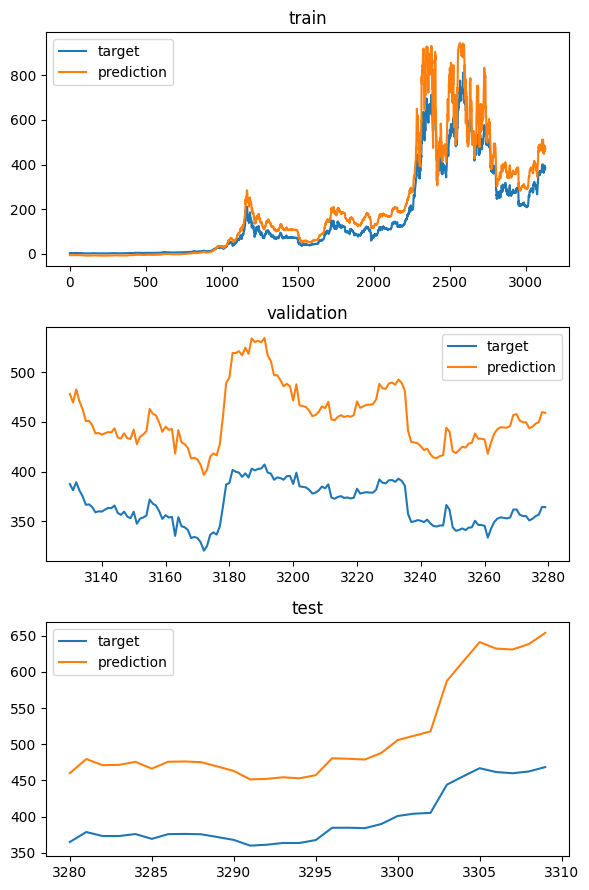

In [193]:
if __name__ == "__main__":
    
  args = {
        "wandb": True,  # Weights & Biases 사용 여부
        "batch_size": 32,  # 배치 크기
        "epochs": 100,  # 학습 epoch 수
        "learning_rate": 0.0001,  # 학습률
        "weight_decay": 0.0001,  # 가중치 감소 값
        "validation_intervals": 1,  # val 간격 (몇 epoch마다 validation 할지)
        "early_stop_patience": 20,  # 조기 종료 patience
        "early_stop_delta": 0.005,  # 조기 종료 delta 값
    }
  args = SimpleNamespace(**args)
  main(args)

# i_crypto_currency_classification_train_lstm

## 문제 1번 URL_2 :https://wandb.ai/persnal/i_lstm_classification_btc_krw/runs/sotx08h1?nw=nwuserlss523012

In [161]:
# next open 다시 삭제

def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=False
):
  btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
  df = pd.read_csv(btc_krw_path)
  row_size = len(df)
  # ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
  date_list = df['Date']

  df = df.drop(columns=['Date'])

  data_size = row_size - sequence_size
  train_size = data_size - (validation_size + test_size)
  #################################################################################################

  row_cursor = 0

  X_train_list = []
  y_train_regression_list = []
  y_train_classification_list = []
  y_train_date = []
  for idx in range(0, train_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_train_list.append(torch.from_numpy(sequence_data))
    y_train_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_train_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_train_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_train = torch.stack(X_train_list, dim=0).to(torch.float)
  y_train_regression = torch.tensor(y_train_regression_list, dtype=torch.float32) / y_normalizer
  y_train_classification = torch.tensor(y_train_classification_list, dtype=torch.int64)

  m = X_train.mean(dim=0, keepdim=True)
  s = X_train.std(dim=0, keepdim=True)
  X_train = (X_train - m) / s

  #################################################################################################

  X_validation_list = []
  y_validation_regression_list = []
  y_validation_classification_list = []
  y_validation_date = []
  for idx in range(row_cursor, row_cursor + validation_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_validation_list.append(torch.from_numpy(sequence_data))
    y_validation_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_validation_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_validation_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_validation = torch.stack(X_validation_list, dim=0).to(torch.float)
  y_validation_regression = torch.tensor(y_validation_regression_list, dtype=torch.float32) / y_normalizer
  y_validation_classification = torch.tensor(y_validation_classification_list, dtype=torch.int64)

  X_validation = (X_validation - m) / s
  #################################################################################################

  X_test_list = []
  y_test_regression_list = []
  y_test_classification_list = []
  y_test_date = []
  for idx in range(row_cursor, row_cursor + test_size):
    sequence_data = df.iloc[idx: idx + sequence_size].values  # sequence_data.shape: (sequence_size, 5)
    X_test_list.append(torch.from_numpy(sequence_data))
    y_test_regression_list.append(df.iloc[idx + sequence_size][target_column])
    y_test_classification_list.append(
      1 if df.iloc[idx + sequence_size][target_column] > df.iloc[idx + sequence_size - 1][target_column] else 0
    )
    y_test_date.append(date_list[idx + sequence_size])
    row_cursor += 1

  X_test = torch.stack(X_test_list, dim=0).to(torch.float)
  y_test_regression = torch.tensor(y_test_regression_list, dtype=torch.float32) / y_normalizer
  y_test_classification = torch.tensor(y_test_classification_list, dtype=torch.int64)

  X_test = (X_test - m) / s

  if is_regression:
    return (
      X_train, X_validation, X_test,
      y_train_regression, y_validation_regression, y_test_regression,
      y_train_date, y_validation_date, y_test_date
    )
  else:
    return (
      X_train, X_validation, X_test,
      y_train_classification, y_validation_classification, y_test_classification,
      y_train_date, y_validation_date, y_test_date
    )


if __name__ == "__main__":
  is_regression = False

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
    sequence_size=10, validation_size=100, test_size=10,
    target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
  )

  for idx, batch in enumerate(train_data_loader):
    input, target = batch
    print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 0, 1, 1])
1 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
2 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 0])
3 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0])
4 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0])
5 - torch.Size([32, 10, 5]): torch.Size([32]), tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        1, 1, 1, 0, 1, 0, 1, 0])
6 - torch.Size([32, 10, 5]): torch.Size(

In [162]:
class ClassificationTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        # 클래스 초기화: 모델, 데이터 로더, 최적화 등 초기화
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # 손실 함수로 교차 엔트로피 사용
        self.loss_fn = nn.CrossEntropyLoss()

    def do_train(self):
        # 모델을 학습 모드로 설정
        self.model.train()

        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            # 데이터 변환(옵션)
            if self.transforms:
                input_train = self.transforms(input_train)

            # 모델 출력 계산
            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)  # 손실 계산
            loss_train += loss.item()

            # 예측값 계산
            predicted_train = torch.argmax(output_train, dim=-1)
            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

            num_trained_samples += len(input_train)
            num_trains += 1

            # 역전파 및 가중치 업데이트
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        train_accuracy = 100.0 * num_corrects_train / num_trained_samples

        return train_loss, train_accuracy

    def do_validation(self):
        # 모델을 평가 모드로 설정
        self.model.eval()

        loss_validation = 0.0
        num_corrects_validation = 0
        num_validated_samples = 0
        num_validations = 0

        with torch.no_grad():  # grad 비활성화
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                # 데이터 변환
                if self.transforms:
                    input_validation = self.transforms(input_validation)

                # 모델 출력 계산
                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(output_validation, target_validation).item()

                # 예측값 계산
                predicted_validation = torch.argmax(output_validation, dim=1)
                num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

                num_validated_samples += len(input_validation)
                num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

        return validation_loss, validation_accuracy

    def train_loop(self):
        # 조기 종료 설정
        early_stopping = EarlyStopping(
            patience=self.wandb.config.early_stop_patience,
            delta=self.wandb.config.early_stop_delta,
            project_name=self.project_name,
            checkpoint_file_path=self.checkpoint_file_path,
            run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            # 학습 및 검증 단계 수행
            train_loss, train_accuracy = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()

                # 진행 시간 및 속도 계산
                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

                # 조기 종료 조건 확인 및 메시지 출력
                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:7.5f}, "
                    f"T_accuracy: {train_accuracy:6.4f} | "
                    f"V_loss: {validation_loss:7.5f}, "
                    f"V_accuracy: {validation_accuracy:6.4f} | "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                # wandb에 로그 저장
                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Training accuracy (%)": train_accuracy,
                    "Validation loss": validation_loss,
                    "Validation accuracy (%)": validation_accuracy,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                # 조기 종료 조건 만족 시 중단
                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

In [163]:
# output이 2개임 => 1 or 0
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=256, num_layers=3, batch_first=True)
      self.fcn = nn.Linear(in_features=256, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

In [164]:
def main(args):
    
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    project_name = "i_lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

   
    print(args)
    print(wandb.config)

    
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)

    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model()
    model.to(device)

    
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    
    wandb.finish()

In [165]:
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 100,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 5,
    "early_stop_delta": 0.01,
    }  

  args = SimpleNamespace(**args)
  main(args)

namespace(wandb=True, batch_size=32, epochs=100, learning_rate=0.001, weight_decay=0.0001, validation_intervals=1, early_stop_patience=5, early_stop_delta=0.01)
{'epochs': 100, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0001, 'early_stop_patience': 20, 'early_stop_delta': 0.005}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69159, T_accuracy: 53.1756 | V_loss: 0.69537, V_accuracy: 51.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69104, T_accuracy: 53.2690 | V_loss: 0.69000, V_accuracy: 51.0000 | V_loss decreased (0.69537 --> 0.69000). Saving model... | T_time: 00:00:01, T_speed: 2.000
[Epoch   3] T_loss: 0.69107, T_accuracy: 53.1133 | V_loss: 0.69309, V_accuracy: 51.0000 | Early stopping counter: 1 out of 20 | T_time: 00:00:01, T_speed: 3.000
[Epoch   4] T_loss: 0.69098, T_accuracy: 53.5492 | V_loss: 0.69100, V_accuracy: 51.0000 | Early stopping counter: 2 out of 20 | T_time: 00:00:02, T_speed: 2.000
[Epoch   5] T_loss

Epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
Training accuracy (%),▄▅▄▇▅▆▇▃▁▄▄▇▃▄▄▆█▆▃▃▂▅
Training loss,█▅▆▅▄▅▄▄▄▄▄▃▃▄▄▅▁▄▄▄▃▄
Training speed (epochs/sec.),▁▆█▆▇▆▅▆▅▆▅▆▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▁▁▁▁▅▁▁▁▁▁▁▁▁▆█▅▁▁▁▁▁▁
Validation loss,█▁▅▂▅▃▆▄▇▂▁▅▄▅▄▄▄▄▅▅█▅
Epoch,22
Training accuracy (%),53.26899
Training loss,0.69084
Training speed (epochs/sec.),1.83333
Validation accuracy (%),51.0


# j_crypto_currency_classification_test_lstm

In [166]:
def test(test_model):
  # 테스트 데이터 로더
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [167]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "j_lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()
  project_name = "i_lstm_classification_btc_krw"

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)

In [168]:
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 10,
    "learning_rate": 0.001,
    "weight_decay": 0.0001,
    "validation_intervals": 1,
    "early_stop_patience": 5,
    "early_stop_delta": 0.01,
    }  

  args = SimpleNamespace(**args)
  main(args)

MODEL FILE: /home/work/LSTM/checkpoints/i_lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 70.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   0.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   1.00


# 문제 2
### wandb url 4: https://wandb.ai/persnal/i_lstm_classification_btc_krw?nw=nwuserlss523012

step

1. 주어진 값에서 epoch 과 patience 증가 각각 50,15 -> 
Training accuracy (%)	53.23786
Training loss	0.6907
Training speed (epochs/sec.)	1.77778
Validation accuracy (%)	51.0
Validation loss	0.69354

일단 성능 향상은 없었음 

2. early_stop_delta:기존의 절반으로 학습률 0.0001로 1에 이어서 진행 ->
Training accuracy (%)	53.26899
Training loss	0.69072
Training speed (epochs/sec.)	1.77778
Validation accuracy (%)	51.0
Validation loss	0.69308

이전과 다른게 없었음

3. hidden 512 layer 4개로 진행
Training accuracy (%)	53.48692
Training loss	0.69062
Training speed (epochs/sec.)	1.6
Validation accuracy (%)	51.0
Validation loss	0.6904

이것도 큰 영향을 주지 못했음 
4. 학습률 0.0001 decay 기존 절반 stopdelta 0.00001 로 진행

Training accuracy (%)	53.58032
Training loss	0.69056
Training speed (epochs/sec.)	2.42857
Validation accuracy (%)	52.0
Validation loss	0.69317

valid의 소폭 상승이 있었음 stopdelta를 더 줄여서 early를 최대한 늦게 해보는걸로 하겠음

5. stopdelta 0.000005로 진행
Training accuracy (%)	53.17559
Training loss	0.69054
Training speed (epochs/sec.)	2.16667
Validation accuracy (%)	51.0
Validation loss	0.69262

기존보다 떨어진 성능 여기서 hidden을 한번 늘려보겠음

6. hidden을 1024로
Training accuracy (%)	53.36239
Training loss	0.69063
Training speed (epochs/sec.)	1.52
Validation accuracy (%)	51.0
Validation loss	0.69097

성능향상이 보이지 않음....

7. 학습률 0.00001 decay; 0.000005 epoch 200으로 진행
Epoch	29
Training accuracy (%)	53.30012
Training loss	0.69041
Training speed (epochs/sec.)	1.52632
Validation accuracy (%)	51.0
Validation loss	0.6911

학습률을 다시 증가시켜봐야겠음

8. 학습률 0.001 decay; 0.0005 로 진행
Training accuracy (%)	53.33126
Training loss	0.69067
Training speed (epochs/sec.)	1.53846
Validation accuracy (%)	51.0
Validation loss	0.69436

이젠 잘 모르겠음....

step 9

기존에  validation 증가가 있었던 parameter를 사용
hidden_size=512 num_layers=2, 
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.0001,
    "weight_decay": 0.000001,
    "validation_intervals": 1,
    "early_stop_patience": 15,
    "early_stop_delta": 0.0001,
    
 -> Epoch	18
Training accuracy (%)	52.95766
Training loss	0.69058
Training speed (epochs/sec.)	2.25
Validation accuracy (%)	51.0
Validation loss	0.69283


In [180]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=512, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=512, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=5, n_output=2)

  return my_model

def main(args):
    # 실행 시각을 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 설정 값을 딕셔너리로 정의
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    # wandb 프로젝트 설정
    project_name = "i_lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 설정값 출력
    print(args)
    print(wandb.config)

    # 데이터 로더 생성 이때 regression false!!
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)

    # 학습 디바이스 설정 (GPU가 있으면 GPU, 없으면 CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성
    model = get_model()
    model.to(device)

    # 최적화 Adam
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

    # 분류 트레이너 초기화 및 학습 루프 실행
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()


if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.0001,
    "weight_decay": 0.000001,
    "validation_intervals": 1,
    "early_stop_patience": 15,
    "early_stop_delta": 0.0001,
    }  

  args = SimpleNamespace(**args)
  main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


namespace(wandb=True, batch_size=32, epochs=50, learning_rate=0.0001, weight_decay=1e-06, validation_intervals=1, early_stop_patience=15, early_stop_delta=0.0001)
{'epochs': 50, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0001, 'early_stop_patience': 15, 'early_stop_delta': 0.0001, 'weight_decay': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69203, T_accuracy: 52.7397 | V_loss: 0.69015, V_accuracy: 51.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69128, T_accuracy: 52.8020 | V_loss: 0.69274, V_accuracy: 57.0000 | Early stopping counter: 1 out of 15 | T_time: 00:00:00, T_speed: 0.000
[Epoch   3] T_loss: 0.69143, T_accuracy: 53.1756 | V_loss: 0.68964, V_accuracy: 49.0000 | V_loss decreased (0.69015 --> 0.68964). Saving model... | T_time: 00:00:01, T_speed: 3.000
[Epoch   4] T_loss: 0.69092, T_accuracy: 53.0199 | V_loss: 0.69227, V_accuracy: 51.0000 | Early stopping counter: 1 out of 15 | T_time: 00:00:01, T_speed:

Epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
Training accuracy (%),▁▂▅▄▂▄▇▇▂▅▄█▅▆▄▃▂▃
Training loss,█▅▅▃▅▂▃▃▃▃▁▂▂▁▂▁▂▁
Training speed (epochs/sec.),▁▁▆█▅▆▅▆▅▅▅▅▅▅▅▅▅▅
Validation accuracy (%),▃█▁▃▃▃▆█▃▅▃▃▃▄▄▃▅▃
Validation loss,▂▅▁▄█▅▅▄▄▄▅▄▆▃▅▅▅▅
Epoch,18
Training accuracy (%),52.95766
Training loss,0.69058
Training speed (epochs/sec.),2.25
Validation accuracy (%),51.0


# 문제 3
url_6 : https://wandb.ai/persnal/i_lstm_classification_btc_krw/runs/florhswu?nw=nwuserlss523012


In [181]:
def get_cryptocurrency_data(
    sequence_size=21, validation_size=150, test_size=30, target_column='Close', y_normalizer=1.0e7, is_regression=False
):
    btc_krw_path = os.path.join(BASE_PATH, "BTC_KRW.csv")
    df = pd.read_csv(btc_krw_path)

    # 'Next_Open' 열 추가
    df['Next_Open'] = df['Open'].shift(-1)  # 'Open' 열을 한 칸 위로 이동
    df = df[:-1]  # 마지막 행 제거 => NaN 발생

    row_size = len(df)
    date_list = df['Date']
    df = df.drop(columns=['Date'])

    data_size = row_size - sequence_size
    train_size = data_size - (validation_size + test_size)

    # 데이터 전처리 함수 정의
    def process_data(start_idx, size):
        X_list = []
        y_list = []
        date_list_out = []

        for idx in range(start_idx, start_idx + size):
            # 시퀀스 데이터와 Next_Open 병합
            sequence_data = df.iloc[idx: idx + sequence_size].values  # 시퀀스 데이터
            next_open = df.iloc[idx + sequence_size]['Next_Open']  # 다음 Open 값

            # 'Next_Open' 값을 시퀀스 데이터의 추가 ==> feature로 포함
            sequence_with_next_open = np.hstack([sequence_data, [[next_open]] * sequence_size])

            X_list.append(sequence_with_next_open)  # 리스트에 numpy 배열 추가
            if is_regression:
                # 회귀 문제: 타겟 값을 정규화하여 추가
                y_list.append(df.iloc[idx + sequence_size][target_column] / y_normalizer)
            else:
                # 분류 문제: 타겟 클래스(상승/하락) 추가
                y_list.append(
                    1 if df.iloc[idx + sequence_size][target_column] >= df.iloc[idx + sequence_size - 1][target_column] else 0
                )
            date_list_out.append(date_list[idx + sequence_size])

        # numpy 배열로 변환
        X_array = np.array(X_list, dtype=np.float32)
        y_array = np.array(y_list, dtype=np.float32 if is_regression else np.int64)

        # numpy 배열을 PyTorch 텐서로 변환
        X = torch.tensor(X_array)
        y = torch.tensor(y_array)

        return X, y, date_list_out

    # 학습, val, 테스트 데이터셋 생성
    X_train, y_train, train_dates = process_data(0, train_size)
    X_validation, y_validation, validation_dates = process_data(train_size, validation_size)
    X_test, y_test, test_dates = process_data(train_size + validation_size, test_size)

    # 학습 데이터 정규화 (평균 및 표준편차 계산)
    m = X_train.mean(dim=0, keepdim=True)
    s = X_train.std(dim=0, keepdim=True)
    # 정규화 적용
    X_train = (X_train - m) / s
    X_validation = (X_validation - m) / s
    X_test = (X_test - m) / s

    # 반환값 구성
    if is_regression:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )
    else:
        return (
            X_train, X_validation, X_test,
            y_train, y_validation, y_test,
            train_dates, validation_dates, test_dates
        )



if __name__ == "__main__":
    # regression true
    is_regression = False

    # 데이터 로드 및 전처리
    X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
        = get_cryptocurrency_data(
        sequence_size=21, validation_size=150, test_size=30,
        target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
    )

    # 학습 데이터셋 생성
    train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train, is_regression=is_regression)
    validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation, is_regression=is_regression)
    test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test, is_regression=is_regression)

    # 데이터 로더 구성
    train_data_loader = DataLoader(
        dataset=train_crypto_currency_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True
    )

    # 데이터 로더 확인
    for idx, batch in enumerate(train_data_loader):
        input, target = batch
        print("{0} - {1}: {2}, {3}".format(idx, input.shape, target.shape, target))

0 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0])
1 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1])
2 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 0])
3 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 1, 1, 1, 1, 0, 1])
4 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 1, 1, 1, 0])
5 - torch.Size([32, 21, 7]): torch.Size([32]), tensor([0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0])
6 - torch.Size([32, 21, 7]): torch.Size(

In [183]:
def get_model():
  class MyModel(nn.Module):
    def __init__(self, n_input, n_output):
      super().__init__()

      self.lstm = nn.LSTM(input_size=n_input, hidden_size=512, num_layers=2, batch_first=True)
      self.fcn = nn.Linear(in_features=512, out_features=n_output)

    def forward(self, x):
      x, hidden = self.lstm(x)
      x = x[:, -1, :]  # x.shape: [32, 128]
      x = self.fcn(x)
      return x

  my_model = MyModel(n_input=7, n_output=2)

  return my_model

def main(args):
    # 실행 시각을 생성
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    # 설정 값을 딕셔너리로 정의
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay
    }

    # wandb 프로젝트 설정
    project_name = "i_lstm_classification_btc_krw"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "classification", "btc_krw"],
        name=run_time_str,
        config=config
    )

    # 설정값 출력
    print(args)
    print(wandb.config)

    # 데이터 로더 생성 이때 regression false!!
    train_data_loader, validation_data_loader, _ = get_btc_krw_data(is_regression=False)

    # 학습 디바이스 설정 (GPU가 있으면 GPU, 없으면 CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    # 모델 생성
    model = get_model()
    model.to(device)

    # 최적화 Adam
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=0.0001)

    # 분류 트레이너 초기화 및 학습 루프 실행
    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

In [184]:
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.0001,
    "weight_decay": 0.000001,
    "validation_intervals": 1,
    "early_stop_patience": 15,
    "early_stop_delta": 0.0001,
    }  

  args = SimpleNamespace(**args)
  main(args)

namespace(wandb=True, batch_size=32, epochs=50, learning_rate=0.0001, weight_decay=1e-06, validation_intervals=1, early_stop_patience=15, early_stop_delta=0.0001)
{'epochs': 50, 'batch_size': 32, 'validation_intervals': 1, 'learning_rate': 0.0001, 'early_stop_patience': 15, 'early_stop_delta': 0.0001, 'weight_decay': 1e-06}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69188, T_accuracy: 51.9153 | V_loss: 0.69428, V_accuracy: 50.0000 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   2] T_loss: 0.69061, T_accuracy: 53.2544 | V_loss: 0.69267, V_accuracy: 50.0000 | V_loss decreased (0.69428 --> 0.69267). Saving model... | T_time: 00:00:00, T_speed: 0.000
[Epoch   3] T_loss: 0.69087, T_accuracy: 53.9396 | V_loss: 0.69186, V_accuracy: 52.0000 | V_loss decreased (0.69267 --> 0.69186). Saving model... | T_time: 00:00:01, T_speed: 3.000
[Epoch   4] T_loss: 0.69084, T_accuracy: 53.1610 | V_loss: 0.69239, V_accuracy: 56.0000 | Early stopping counter: 1 out of 15 | T_time

[Epoch  48] T_loss: 0.56458, T_accuracy: 67.6736 | V_loss: 0.53210, V_accuracy: 71.0000 | V_loss decreased (0.53414 --> 0.53210). Saving model... | T_time: 00:00:23, T_speed: 2.087
[Epoch  49] T_loss: 0.55942, T_accuracy: 68.5145 | V_loss: 0.50718, V_accuracy: 69.0000 | V_loss decreased (0.53210 --> 0.50718). Saving model... | T_time: 00:00:24, T_speed: 2.042
[Epoch  50] T_loss: 0.55605, T_accuracy: 69.1996 | V_loss: 0.49962, V_accuracy: 83.0000 | V_loss decreased (0.50718 --> 0.49962). Saving model... | T_time: 00:00:24, T_speed: 2.083
Final training time: 00:00:24


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Training accuracy (%),▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇█▇█
Training loss,████████▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▆▅▅▄▄▄▄▃▃▃▃▂▁▁
Training speed (epochs/sec.),▁▁█▆▆▆▆▆▆▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
Validation accuracy (%),▁▁▁▂▁▁▃▄▁▄▁▃▃▃▃▃▂▂▂▂▃▁▅▄▃▄▄▆▅▆▇▇▅▅▄▆▃▅▅█
Validation loss,█████████▇██▇▇▇▇▇▇▇█▇█▇▆▆▆▅▆▅▄▅▄▃▃▅▂▃▃▂▁
Epoch,50
Training accuracy (%),69.19963
Training loss,0.55605
Training speed (epochs/sec.),2.08333
Validation accuracy (%),83.0


In [188]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "j_lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model()
  project_name = "i_lstm_classification_btc_krw"

  latest_file_path = os.path.join(
    CHECKPOINT_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
    
if __name__ == "__main__":
  args = {
    "wandb": True,
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.0001,
    "weight_decay": 0.000001,
    "validation_intervals": 1,
    "early_stop_patience": 15,
    "early_stop_delta": 0.0001,
    }  

  args = SimpleNamespace(**args)
  main(args)

MODEL FILE: /home/work/LSTM/checkpoints/i_lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 100.000%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   1.00
 2:   0.00 <-->   0.00
 3:   0.00 <-->   0.00
 4:   1.00 <-->   1.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   1.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   1.00


# 성능에 대한 고찰

regression 모델의 경우 낮은 validation loss를 통해 얼추 target graph와 거의 비슷한 그래프를 만들 수 있었습니다. next_open feature를 받았을 경우 두 모델 모두 성능의 향상이 비약적으로 향상되게 되는걸 확인 하였는데 regression의 경우 그래프가 세부적으로 target 그래프를 근사하는 것에 가장 중요한 역할을 했다는 것을 알 수 있었습니다. classification의 경우에는 다른 parameter들로는 정말 끄떡 없던 accurancy 가 특징의 추가를 통해 비약적으로 상승하는 것을 보고 기분이 좋았던 것 같습니다. 분류 문제에 관해서는 어떤 부분이 성능의 향상을 불어 일으키는지는 정확하게 파악하지 못하여 아쉬웠습니다. 
회귀 문제의 경우 hidden 사이즈나 epoch에 따라 loss율이 확실하게 차이가 났기 때문에 parameter 조정이 쉬웠고, 대부분 hidden size와 학습률에 가장 큰 영향을 받는 것처럼 보였습니다. 이것을 운좋게 잘 선택하여 loss를 낮추었던 것이 도움이 된것 같습니다. 


# 숙제 후기
이번 마지막 숙제를 통해 lstm의 모델 구축을 해보았습니다. 여기서 시계열 데이터의 처리를 하면서 lstm의 모델의 유용성을 확인 할 수 있었고, 정말 생각보다 parameter를 찾는것도 운의 영역이라는 것을 알 게 되었습니다. 주먹 구구 식으로 하다보면 언젠가 찾게는 되겠지만, 쉽지 않을 것이라는 느낌을 받았습니다. 그리고 내가 활용할 수 있는 데이터가 있다면 일단 모두 활용해보는것이 좋다라는 것을  next_open을 통해 알 수 있었습니다. 나중에도 데이터에 대한 이해와 모델을 구축할 때 정말 유용한 경험이 될 것 같습니다. 